In [1]:
import os
import pathlib
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

import time
import cv2


%matplotlib inline

In [2]:
from object_detection.utils import visualization_utils as vis_utils

In [3]:
def load_model(path_saved_model):
    return tf.saved_model.load(path_saved_model)

In [4]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'my_model/pascal_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
print(category_index)

{1: {'id': 1, 'name': 'aeroplane'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'bird'}, 4: {'id': 4, 'name': 'boat'}, 5: {'id': 5, 'name': 'bottle'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'car'}, 8: {'id': 8, 'name': 'cat'}, 9: {'id': 9, 'name': 'chair'}, 10: {'id': 10, 'name': 'cow'}, 11: {'id': 11, 'name': 'diningtable'}, 12: {'id': 12, 'name': 'dog'}, 13: {'id': 13, 'name': 'horse'}, 14: {'id': 14, 'name': 'motorbike'}, 15: {'id': 15, 'name': 'person'}, 16: {'id': 16, 'name': 'pottedplant'}, 17: {'id': 17, 'name': 'sheep'}, 18: {'id': 18, 'name': 'sofa'}, 19: {'id': 19, 'name': 'train'}, 20: {'id': 20, 'name': 'tvmonitor'}}


In [5]:
detection_model = load_model("my_model/save_model_input_float_no_fix_shape/saved_model")

In [6]:
print(detection_model.signatures['serving_default'])

ConcreteFunction signature_wrapper(*, input_tensor)
  Args:
    input_tensor: float32 Tensor, shape=(None, None, None, 3)
  Returns:
    {'detection_anchor_indices': <1>, 'detection_boxes': <2>, 'detection_classes': <3>, 'detection_multiclass_scores': <4>, 'detection_scores': <5>, 'num_detections': <6>, 'raw_detection_boxes': <7>, 'raw_detection_scores': <8>}
      <1>: float32 Tensor, shape=(None, 100)
      <2>: float32 Tensor, shape=(None, 100, 4)
      <3>: float32 Tensor, shape=(None, 100)
      <4>: float32 Tensor, shape=(None, 100, 21)
      <5>: float32 Tensor, shape=(None, 100)
      <6>: float32 Tensor, shape=(None,)
      <7>: float32 Tensor, shape=(None, None, 4)
      <8>: float32 Tensor, shape=(None, None, 21)


In [7]:
detection_model.signatures['serving_default'].output_dtypes

{'num_detections': tf.float32,
 'raw_detection_boxes': tf.float32,
 'detection_scores': tf.float32,
 'detection_boxes': tf.float32,
 'detection_anchor_indices': tf.float32,
 'raw_detection_scores': tf.float32,
 'detection_multiclass_scores': tf.float32,
 'detection_classes': tf.float32}

In [8]:
detection_model.signatures['serving_default'].output_shapes

{'num_detections': TensorShape([None]),
 'raw_detection_boxes': TensorShape([None, None, 4]),
 'detection_scores': TensorShape([None, 100]),
 'detection_boxes': TensorShape([None, 100, 4]),
 'detection_anchor_indices': TensorShape([None, 100]),
 'raw_detection_scores': TensorShape([None, None, 21]),
 'detection_multiclass_scores': TensorShape([None, 100, 21]),
 'detection_classes': TensorShape([None, 100])}

In [62]:
store_output=None
output_model = None

In [63]:
def run_inference_float_for_single_image(model, image):
    global store_output, output_model
    image = np.asarray(image)
    # image = 1-image/255.
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image,dtype=tf.float32)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]
    print("input tensor: ", input_tensor.shape)
    # Run inference
    model_fn = model.signatures['serving_default']
    # print(model_fn)
    output_dict = model_fn(input_tensor)
    output_model = output_dict
    # print(output_dict)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    store_output = output_dict
    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                  output_dict['detection_masks'], output_dict['detection_boxes'],
                   image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                           tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

In [64]:
def show_inference(model, image_path):
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.array(Image.open(image_path))
    # Actual detection.
    output_dict = run_inference_float_for_single_image(model, image_np)
    # Visualization of the results of a detection.
    vis_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8,
      min_score_thresh=.4,)

    display(Image.fromarray(image_np))


input tensor:  (1, 675, 1200, 3)


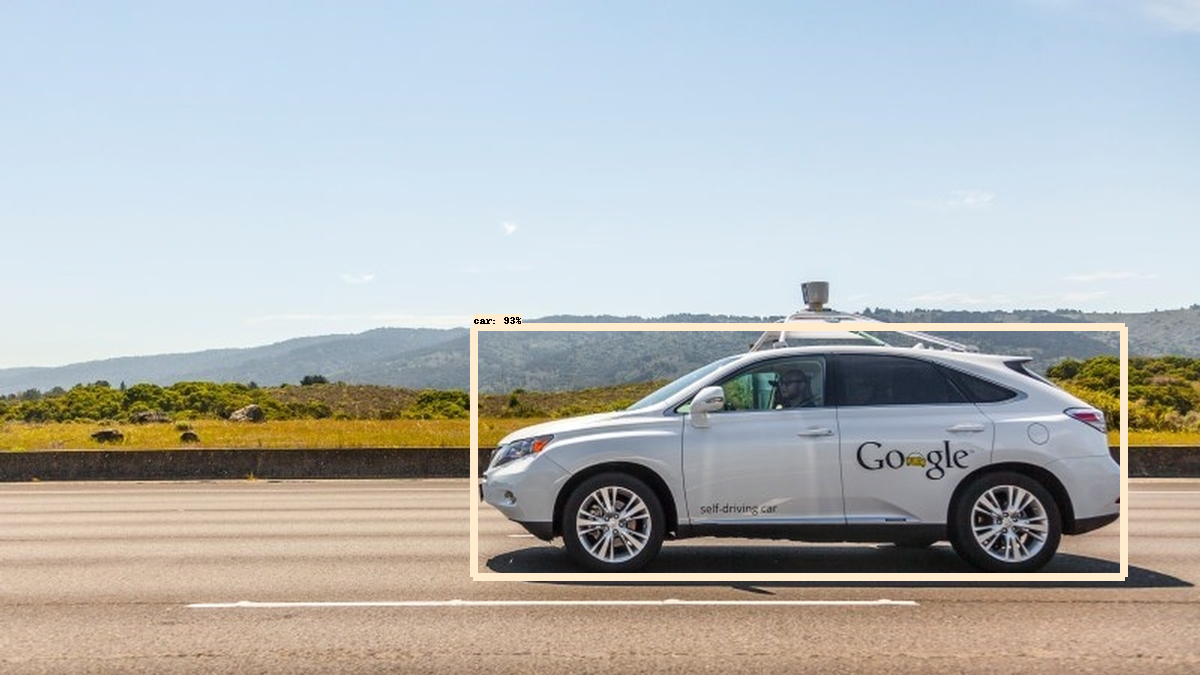

In [65]:
show_inference(detection_model, "image.jpg")

In [66]:
store_output.keys()

dict_keys(['raw_detection_boxes', 'detection_scores', 'detection_boxes', 'detection_anchor_indices', 'raw_detection_scores', 'detection_multiclass_scores', 'detection_classes', 'num_detections'])

In [67]:
boxes = store_output['detection_boxes']
scores = store_output['detection_scores']
classes = store_output['detection_classes']

In [81]:
print(boxes.shape)
print(scores.shape)
print(classes.shape)
print(store_output['num_detections'])

(100, 4)
(100,)
(100,)
100


In [69]:
print(tuple(boxes[0].tolist()))

(0.4851039946079254, 0.3947853744029999, 0.8545639514923096, 0.9374363422393799)


In [70]:
# ymin, xmin, ymax, xmax = box
# (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
#                                   ymin * im_height, ymax * im_height)

In [71]:
def extract_output(output_dict):
    boxx = output_dict['detection_boxes']
    scoree = output_dict['detection_scores']
    classs = output_dict['detection_classes']
    print(boxes.shape)
    print(scores.shape)
    print(classes.shape)
    list_box = []
    list_score = []
    list_class = []
    for i in range(boxx.shape[0]):
        box = boxx[i]
        if scoree[i] > 0.7:
            list_box.append(box)
            list_score.append(scoree[i])
            list_class.append(classs[i])
    print(list_box)
    print(list_score)
    print(list_class)

In [72]:
extract_output(store_output)

(100, 4)
(100,)
(100,)
[array([0.485104  , 0.39478537, 0.85456395, 0.93743634], dtype=float32)]
[0.92542976]
[7]


In [73]:
image = cv2.imread("image.jpg")
print(image.shape)


(675, 1200, 3)


In [74]:
ymin,xmin,ymax,xmax = 0.485104*675,0.39478537*1200, 0.85456395*675, 0.93743634*1200

In [75]:
print(ymin,xmin,ymax,xmax)

327.4452 473.74244400000003 576.8306662499999 1124.923608


In [76]:
image = cv2.rectangle(image, (int(xmin),int(ymin)),(int(xmax),int(ymax)),(255,0,0),1)

In [77]:
cv2.imwrite("predicts.jpg", image)

True

In [78]:
print(type(output_model))

<class 'dict'>


In [79]:
print(output_model.keys())

dict_keys(['raw_detection_boxes', 'detection_scores', 'detection_boxes', 'detection_anchor_indices', 'raw_detection_scores', 'detection_multiclass_scores', 'detection_classes'])


In [87]:
for key,value in output_model.items():
    print(key,value)

raw_detection_boxes tf.Tensor(
[[[-8.4901135e-04  1.7925445e-03  2.7814995e-02  4.1263469e-02]
  [-2.6746020e-03 -5.6671914e-02  5.3693600e-02  1.7784144e-01]
  [-6.2503085e-02 -7.3883049e-03  2.0928983e-01  7.1142882e-02]
  ...
  [ 2.2116929e-01 -2.8145909e-02  7.6220149e-01  1.0367035e+00]
  [-7.7032506e-02  2.0318207e-01  1.0883822e+00  7.9083025e-01]
  [ 1.7973641e-01  6.1771691e-02  8.4294522e-01  8.7465119e-01]]], shape=(1, 2034, 4), dtype=float32)
detection_scores tf.Tensor(
[[0.92542976 0.32253918 0.3223005  0.2569924  0.2200813  0.21517801
  0.20168053 0.18977958 0.18555519 0.18268415 0.1777027  0.16862576
  0.16697033 0.15814638 0.15446576 0.1540873  0.15332331 0.14844643
  0.1480513  0.14513546 0.14439596 0.14385357 0.13884278 0.13845691
  0.13843651 0.13751014 0.13733074 0.13712671 0.13656619 0.13231441
  0.13177204 0.13143583 0.13018641 0.12881333 0.12562475 0.12523124
  0.12491936 0.12318639 0.12301908 0.12278215 0.12150323 0.12101868
  0.11818966 0.11750597 0.11649279 0.